In [1]:
from pyannote.core import Annotation
from pyannote.pipeline import Optimizer
from pyannote.metrics.detection import DetectionErrorRate
from pyannote.database import registry, get_protocol, FileFinder
from pyannote.audio.tasks import VoiceActivityDetection
from pyannote.audio.models.segmentation import PyanNet
from pyannote.audio import Inference
from pyannote.audio.pipelines import VoiceActivityDetection as VoiceActivityDetectionPipeline
from utils import Get_RTTM
import pytorch_lightning as pl
import os

/home/wuxiaohui9707/miniconda3/envs/myenv/lib/python3.8/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/home/wuxiaohui9707/miniconda3/envs/myenv/lib/python3.8/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
torchvision is not available - cannot save figures


Load Database (The label attempts to separate the different events, but does not indicate the specific event)

In [7]:
# Load database and set environment variable
registry.load_database(
    os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets', 'yaml','My_Databases.yml')
)
os.environ["PYANNOTE_DATABASE_CONFIG"] = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets','yaml', 'My_Databases.yml')

'My_datasets.SpeakerDiarization.Detection' found in /mnt/e/Files/Acoustic_Data/Datasets/yaml/My_Databases.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


Get Protocol

In [8]:
# Get protocol and initial training file
preprocessors = {"audio": FileFinder()}
cow_audio = get_protocol('My_datasets.SpeakerDiarization.Detection', preprocessors=preprocessors)

In [9]:
# Train the VAD model
vad = VoiceActivityDetection(cow_audio, duration=1.5, batch_size=16)
model = PyanNet(sincnet={'stride': 10}, task=vad)
model.to("cuda")
output_directory = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets')
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=10, default_root_dir=output_directory)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Protocol My_datasets.SpeakerDiarization.Detection does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | In sizes      | Out sizes                                 
--------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 24000] | [1, 60, 86]                               
1 | lstm              | LSTM             | 589 K  | [1, 86, 60]   | [[1, 86, 256], [[4, 1, 128], [4, 1, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?             | ?                                         
3 | classifier        | Linear           | 129    | [1, 86, 128]  | [1, 86, 1]                                
4 | activation        | Sigmoid          | 0      | [1, 86, 1]    | [1, 86, 1]                                
5 | validation_metric | MetricCollection | 0      | ?             | ?                                         
---------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


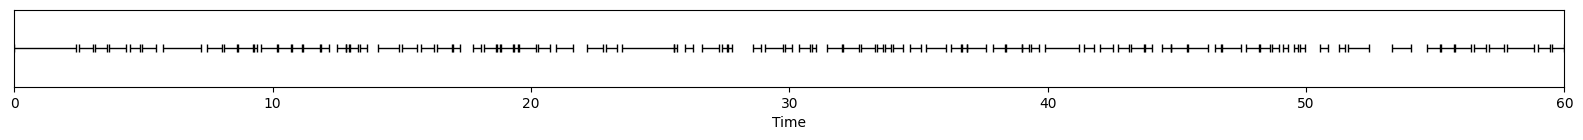

In [10]:
# Use the trained model for inference
test_files = list(cow_audio.test())
test_file = test_files[0] 
inference = Inference(model)
vad_probability = inference(test_file)
#vad_probability
expected_output = test_file["annotation"].get_timeline().support()
expected_output

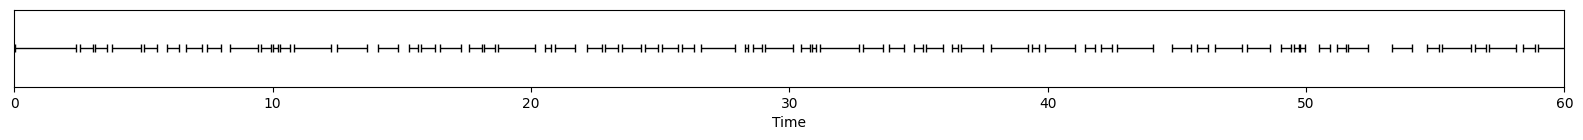

In [11]:
# Convert output to timeline and then to RTTM format
pipeline = VoiceActivityDetectionPipeline(segmentation=model)
initial_params = {"onset": 0.6, "offset": 0.5, "min_duration_on": 0.0, "min_duration_off": 0.0}
pipeline.instantiate(initial_params)
timeline = pipeline(test_file).get_timeline()
pipeline(test_file).get_timeline()

In [12]:
metric = DetectionErrorRate()

for file in cow_audio.test():
    
    # apply the voice activity detection pipeline
    speech = pipeline(file)

    # evaluate its output
    _ = metric(
        file['annotation'],     # this is the reference annotation
        speech,                 # this is the hypothesized annotation
        uem=file['annotated'])  # this is the part of the file that should be evaluated
    
# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 22.6%


{'onset': 0.6, 'offset': 0.5, 'min_duration_on': 0.0, 'min_duration_off': 0.0}


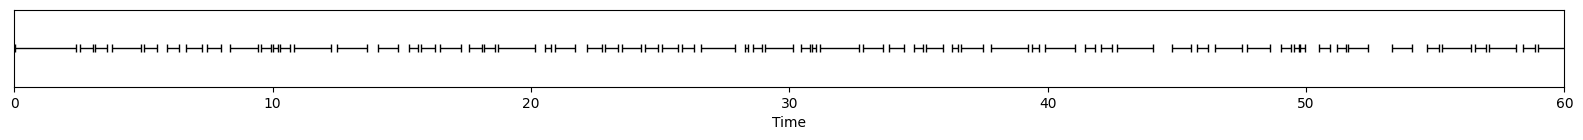

In [14]:
# Optimize parameters
optimizer = Optimizer(pipeline)
optimizer.tune(list(cow_audio.development()), 
               warm_start=initial_params, 
               n_iterations=20, 
               show_progress=False)
optimized_params = optimizer.best_params
print(optimized_params)

pipeline.instantiate(optimized_params)
optimized_pipeline = pipeline.instantiate(optimized_params)
pipeline(test_file).get_timeline()

In [15]:
metric = DetectionErrorRate()

for file in cow_audio.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])
    
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 22.6%
